# 4 - AutoEncoders

In [ ]:
# %pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("zalando-research/fashionmnist")

# print("Path to dataset files:", path)

In [4]:
%pip install tensorflow



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 4 - 1 Normalization and Preprocessing

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist

In [7]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Auto_Encoder:
    def __init__(self, encoder_layers, decoder_layers, latent_dimensions):
        # Build encoder
        self.encoder = tf.keras.Sequential()
        self.encoder.add(layers.Input(shape=(28, 28, 1)))
        self.encoder.add(layers.Flatten())
        
        for i in range(encoder_layers - 1):
            self.encoder.add(layers.Dense(latent_dimensions * 2, activation='relu'))
        self.encoder.add(layers.Dense(latent_dimensions, activation='relu'))  # latent layer
        
        # Build decoder
        self.decoder = tf.keras.Sequential()
        for i in range(decoder_layers - 1):
            self.decoder.add(layers.Dense(latent_dimensions * 2, activation='relu'))
        self.decoder.add(layers.Dense(28 * 28, activation='sigmoid'))
        self.decoder.add(layers.Reshape((28, 28, 1)))
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:
class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(28 * 28, activation='relu'),
            layers.Reshape((28, 28, 1))
        ])
    
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
latent_dimensions = 64
autoencoder = SimpleAutoencoder(latent_dimensions)
autoencoder.compile(optimizer='adamw', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

ValueError: Could not interpret optimizer identifier: adamdw

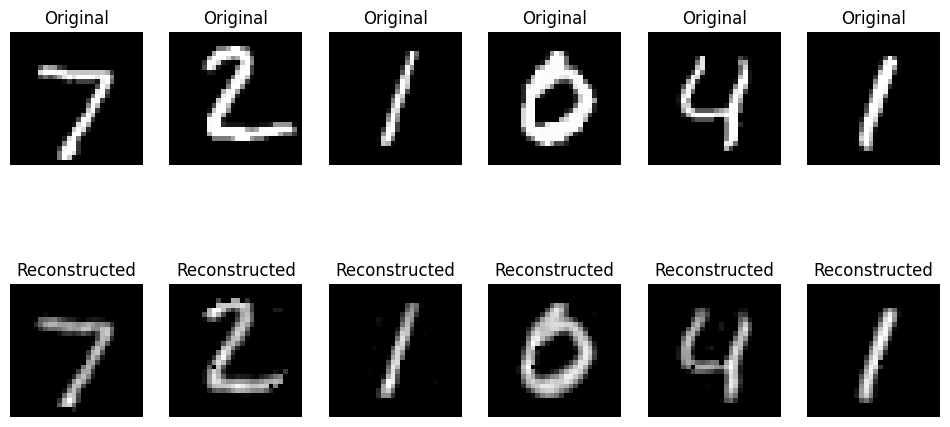

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 6
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()